In [57]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from tueplots import figsizes
from tueplots import axes
from numpy.linalg import cholesky

from ode_filters.GMP_priors import IWP, taylor_mode_initialization
from ode_filters.ODE_filter_loop import ekf1_sqr_loop, rts_sqr_smoother_loop

#plitting specifications
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})
figsize_config = figsizes.aaai2024_half(nrows=1, ncols=2)
plt.rcParams.update(figsize_config)
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

### Problem

In [74]:
#define the problem itself
#define IVP -> ODE + IV
def vf(x):
    return x*(1-x)

t0 = 0
t1 = 10
x0 = np.array([0.01])
d = x0.shape[0]

### Model

In [96]:
#prior 
q = 2
prior = IWP(q, d)

# domain discretization
N = 30 # or vice verca define h -> N = (t1-t0)/h + 1
ts, h = np.linspace(t0, t1, N+1, retstep=True)
A_h = prior.A(h)
Q_h = prior.Q(h)

In [97]:
# parameters
D = d*(q+1)
mu_0 = taylor_mode_initialization(vf, x0, q)
Sigma_0 = np.zeros((D,D))
b_h = np.zeros(D)
if np.any(Sigma_0 != 0):
    Sigma_0_sqr = cholesky(Sigma_0, upper=True)
else:
    Sigma_0_sqr = Sigma_0
Q_h_sqr = cholesky(Q_h, upper=True)

In [98]:
k = 0 #number of extra observations totla summed dimension
R_h_sqr = np.zeros(d+k)

#define projection matrices
E0 = np.zeros(q+1)
E0[0]=1.
E1 = np.zeros(q+1)
E1[1]=1.
E0 = np.kron(E0, np.eye(d))
E1 = np.kron(E1, np.eye(d))

def g(X):
    g_ODE = E1@X - vf(E0@X)
    return g_ODE
    
jacobian_g = jax.jacfwd(g)
z_sequence = np.zeros(N).reshape(-1,1)

In [99]:
#apply ODE filter
results = ekf1_sqr_loop(
    mu_0, Sigma_0_sqr, A_h, b_h, Q_h_sqr, R_h_sqr, g, jacobian_g, z_sequence, N)

In [100]:
m_seq, P_seq_sqr, m_pred_seq, P_pred_seq_sqr, G_back_seq, d_back_seq, P_back_seq_sqr, mz_seq, Pz_seq_sqr = results

In [101]:
m_smoothed, P_sqr_smoothed = rts_sqr_smoother_loop(m_seq[-1], P_seq_sqr[-1], G_back_seq, d_back_seq, P_back_seq_sqr, N)

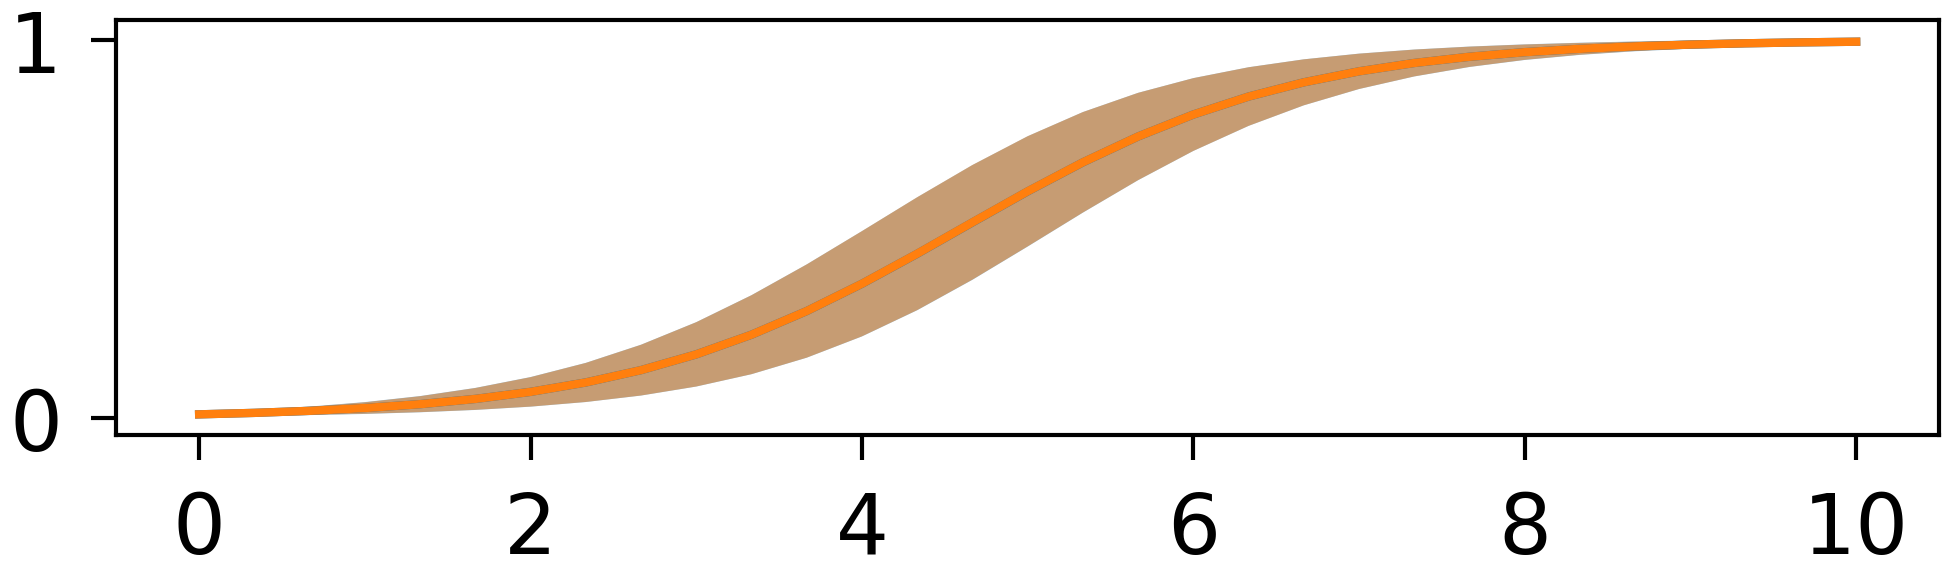

In [103]:
i=0
plt.figure()
plt.plot(ts, m_seq[:,i])
#plt.ylim([-0.2,1.2])
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2*np.sqrt(P_seq[:,i,i])
plt.fill_between(ts, m_seq[:,i]-margin, m_seq[:,i]+margin, alpha=0.5)
#smoothed results
plt.plot(ts, m_smoothed[:,i])
P_seq = np.matmul(np.transpose(P_sqr_smoothed, (0, 2, 1)), P_sqr_smoothed)
margin = 2*np.sqrt(P_seq[:,i,i])
plt.fill_between(ts, m_smoothed[:,i]-margin, m_smoothed[:,i]+margin, alpha=0.5)
plt.show()

In [7]:
import jax
import jax.numpy as jnp
import jax.experimental.jet
import numpy as np
from ode_filters.GMP_priors import taylor_mode_initialization

In [8]:
def vf(y):  # noqa: ARG001
    """Evaluate the dynamics of the logistic ODE."""
    return y * (1 - y)

y0 = jnp.array([0.01])

In [9]:
vf(y0)
vf_grad = jax.grad(vf)
vf_jacobi = jax.jacfwd(vf)
print(vf_grad(0.01))
print(vf_jacobi(y0))

0.98
[[0.98]]


In [10]:
# Compute the Jacobian of vf using jax.jacfwd
mu0 = [y0, vf(y0)]
jacobi1 = lambda a: jax.jacfwd(vf)(a)*vf(a)
x_next = jacobi1(y0)
mu0.append(x_next.squeeze())
jacobi2 = lambda a: jax.jacfwd(jacobi1)(a)*vf(a)
x_next = jacobi2(y0)
mu0.append(x_next.squeeze())
print(mu0)

[Array([0.01], dtype=float32), Array([0.0099], dtype=float32), Array(0.009702, dtype=float32), Array(0.00931194, dtype=float32)]


In [11]:
def _subsets(x, /, n):
    """Compute staggered subsets.

    See example below.

    Examples
    --------
    >>> a = (1, 2, 3, 4, 5)
    >>> print(_subsets(a, n=1))
    [(1, 2, 3, 4, 5)]
    >>> print(_subsets(a, n=2))
    [(1, 2, 3, 4), (2, 3, 4, 5)]
    >>> print(_subsets(a, n=3))
    [(1, 2, 3), (2, 3, 4), (3, 4, 5)]
    """

    def mask(i):
        return None if i == 0 else i

    return [x[mask(k) : mask(k + 1 - n)] for k in range(n)]

In [12]:
# Initial Taylor series (u_0, u_1, ..., u_k)
inits = y0
primals = vf(y0)
tcoeffs = [*inits, primals]
num_arguments = 1
for _ in range(4):
    series = _subsets(tcoeffs[1:], num_arguments)
    p, s_new = jax.experimental.jet.jet(vf, primals=inits, series=series)
    tcoeffs = [*inits, p, *s_new]
    print(series)



[[Array([0.0099], dtype=float32)]]
[[Array(0.0099, dtype=float32), Array([0.009702], dtype=float32)]]
[[Array(0.0099, dtype=float32), Array(0.009702, dtype=float32), Array([0.00931194], dtype=float32)]]
[[Array(0.0099, dtype=float32), Array(0.009702, dtype=float32), Array(0.00931194, dtype=float32), Array([0.0085494], dtype=float32)]]


In [13]:
# Initial Taylor series (u_0, u_1, ..., u_k)
inits = y0
tcoeffs = [inits, vf(y0)]
for _ in range(3):
    series = [tcoeffs[1:]]
    p, s_new = jax.experimental.jet.jet(vf, primals=inits, series=series)
    coeffs = jax.tree.map(lambda c: jnp.atleast_1d(c), s_new)
    tcoeffs = [inits, p, *coeffs]            # everything has ≥1 dims

flat = jnp.concatenate([jnp.atleast_1d(x) for x in series[0]])
flat = jnp.concat([y0, flat])
print(flat)

[0.01       0.0099     0.009702   0.00931194]


In [14]:
def flatten_coeffs(coeffs):
    # Works for scalars, vectors, or nested pytree leaves
    leaves = jax.tree_util.tree_leaves(coeffs)
    return jnp.concatenate([jnp.ravel(arr) for arr in leaves])

inits = y0
tcoeffs = [inits, vf(inits)]

for _ in range(3):
    p, s_new = jax.experimental.jet.jet(
        vf,
        primals=inits,
        series=[tcoeffs[1:]],  # pass only higher-order terms
    )
    tcoeffs = [inits, p, *s_new]

flat = flatten_coeffs(tcoeffs)
print(flat)

[0.01       0.0099     0.009702   0.00931194 0.0085494 ]


In [15]:
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0, ((1-2*y0)**2 - 2*y0*(1-y0))*y0*(1-y0)])
print(X_0.flatten())

[0.01       0.0099     0.009702   0.00931194]


In [16]:
from probdiffeq import taylor, ivpsolvers 
# this computes taylor expansion of vf, up to order num, arround u0, and return the coefficient
tcoeffs = taylor.odejet_padded_scan(vf, (y0,), num=4)
print((tcoeffs))

tcoeffs2 = taylor.odejet_unroll(vf, (y0,), 4)
print(tcoeffs2)

[Array([0.01], dtype=float32), Array([0.0099], dtype=float32), Array([0.009702], dtype=float32), Array([0.00931194], dtype=float32), Array([0.0085494], dtype=float32)]
[Array([0.01], dtype=float32), Array([0.0099], dtype=float32), Array([0.009702], dtype=float32), Array([0.00931194], dtype=float32), Array([0.0085494], dtype=float32)]


In [17]:
#from ode_filters.GMP_priors import taylor_mode_initialization

taylor_mode_initialization(vf, y0, 3)

Array([0.01      , 0.0099    , 0.009702  , 0.00931194], dtype=float32)

In [18]:
from probdiffeq import taylor, ivpsolvers 
#compare init for higher order inputs
def vf(y):
    """Evaluate the Lotka-Volterra vector field."""
    y0, y1 = y[0], y[1]

    y0_new = 0.5 * y0 - 0.05 * y0 * y1
    y1_new = -0.5 * y1 + 0.05 * y0 * y1
    return jnp.asarray([y0_new, y1_new])

y0 = jnp.array([1,2])
tcoeffs = taylor.odejet_padded_scan(vf, (y0,), num=3)
print((tcoeffs))

[Array([1, 2], dtype=int32), Array([ 0.4, -0.9], dtype=float32), Array([0.20500001, 0.445     ], dtype=float32), Array([ 0.09574999, -0.21574998], dtype=float32)]


In [19]:
taylor_mode_initialization(vf, y0, 4)

Array([ 1.        ,  2.        ,  0.4       , -0.9       ,  0.205     ,
        0.445     ,  0.09575001, -0.21575   ,  0.05006251,  0.1056875 ],      dtype=float32)

In [20]:
# Initial Taylor series (u_0, u_1, ..., u_k)
inits = y0
primals = vf(y0)
tcoeffs = [*inits, *primals]
num_arguments = 2
for _ in range(4):
    series = _subsets(tcoeffs[1:], num_arguments)
    p, s_new = jax.experimental.jet.jet(vf, primals=inits, series=series)
    tcoeffs = [*inits, p, *s_new]
    print(series)

TypeError: vf() takes 1 positional argument but 2 were given

In [ ]:
inits = y0
tcoeffs = [inits, vf(inits)]
print(tcoeffs[1:][0])
print(inits)
print(tcoeffs[1:])

for _ in range(3):
    p, s_new = jax.experimental.jet.jet(
        vf,
        primals=inits,
        series=tcoeffs[1:],  # pass only higher-order terms
    )
    tcoeffs = [inits, p, *s_new]
    print(tcoeffs)

[0.0099]
[0.01]
[Array([0.0099], dtype=float32)]
[Array([0.01], dtype=float32), Array(0.0099, dtype=float32), Array(0.009702, dtype=float32)]


TypeError: len() of unsized object